In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb

In [2]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.simclr import *

## 1) Pretraining

In [4]:
from iwang_utils import *

In [5]:
opt_kwargs = dict(sqr_mom=0.99, mom=0.95, beta=0., eps=1e-4)
opt_func = partial(ranger, **opt_kwargs)

In [6]:
bs, resize, size = 512, 256, 224
use_wandb = False

In [7]:
checkpoint, n_checkpoint = True, 2

In [8]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

By using gradient checkpointing and fp16 we can easily fit 256 samples (224 px) per batch and it only occupies 8 GB of GPU memory. Which means on a 16 GB GPU machine we can train with 512 batch size. Eventhough gradient checkpointing trades speed for more memory we don't see a decrease in training speed per epoch, in the contrary it improves by 10-25% due to large batch sizes leading to less steps per epoch.

In [9]:
if checkpoint: encoder = CheckpointSequential(encoder, checkpoint_nchunks=n_checkpoint)

In [10]:
if use_wandb:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SimCLR"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);
    cbs += [WandbCallback(log_preds=False,log_model=False)]
else: cbs = []

In [11]:
cbs += [SimCLR(size, aug_func=get_batch_augs, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False), TerminateOnNaNCallback()] 
dls = get_dls(resize, bs, with_labels=False)
model = create_simclr_model(encoder, n_in=3)
learn = Learner(dls, model, loss_func=noop, cbs=cbs)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Showing images will consume gpu memory if you are working on a gpu since they are loaded to default_device. After inspecting augmentations you should restart the notebook and skip this step to regain that gpu memory.

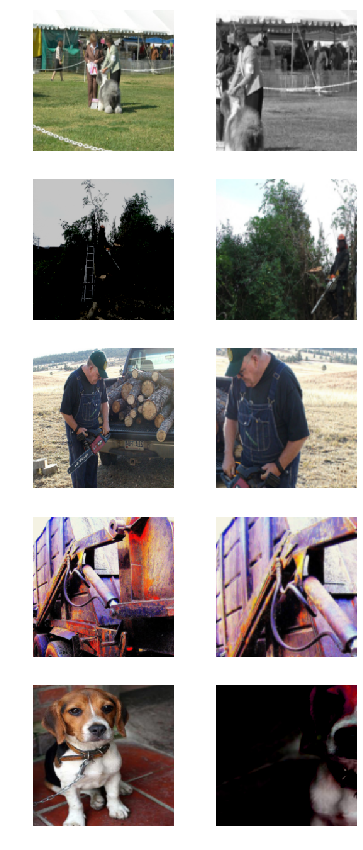

In [12]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clr.show(n=5)

In [13]:
lr,wd,epochs=1e-2,1e-2,50

In [14]:
learn.to_fp16()
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,6.110602,6.177089,01:19
1,5.705964,5.104801,01:18
2,5.365587,4.959358,01:17
3,4.996803,4.234604,01:18
4,4.458251,4.008366,01:21
5,4.142467,3.857325,01:19
6,3.794016,3.765843,01:19
7,3.575277,4.440203,01:19
8,3.383183,3.058284,01:19
9,3.113814,2.134101,01:19


In [15]:
if use_wandb: wandb.finish()

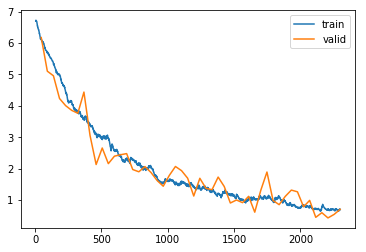

In [16]:
learn.recorder.plot_loss()

In [17]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

## 2) Finetuning (Downstream Task)

In [18]:
def create_finetune_learner(size, bs, encoder_path, opt_func, arch='xresnet34', checkpoint=True, n_checkpoint=2):
    # create dataloader
    dls = get_finetune_dls(size, bs=bs//2)
    
    # load pretrained weights
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    if checkpoint: encoder = CheckpointSequential(encoder, checkpoint_nchunks=n_checkpoint)
    encoder.load_state_dict(pretrained_encoder)
    
    # create new classifier head
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    
    # create model and learner
    model = nn.Sequential(encoder, classifier)
    learner = Learner(dls, model, opt_func=opt_func,
                    metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learner

@delegates(create_finetune_learner)
def finetune(epochs, lr, wd, **kwargs):
    learner = create_finetune_learner(**kwargs)
    learner.unfreeze()
    learner.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [19]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(epochs=5, lr=lr, wd=wd,
                                       bs=256, size=size,
                                       encoder_path=f'models/simclr_iwang_sz{size}_epc{epochs}_encoder.pth', opt_func=opt_func)]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.504999,2.563362,0.242301,0.724866,00:53
1,1.348803,2.390673,0.298040,0.775770,00:53
2,1.293751,2.264187,0.360143,0.797658,00:54
3,1.229031,2.291025,0.350725,0.810130,00:53
4,1.149564,2.159818,0.406719,0.826673,00:53


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.506325,2.642055,0.207941,0.731229,00:53
1,1.361758,2.505719,0.281242,0.758972,00:53
2,1.282794,2.378272,0.321456,0.790023,00:53
3,1.234966,2.372770,0.325274,0.777297,00:53
4,1.142441,2.127969,0.414609,0.835836,00:53


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.532112,2.518922,0.248409,0.748282,00:53
1,1.365788,2.376985,0.315602,0.786460,00:53
2,1.286930,2.292249,0.348180,0.801985,00:53
3,1.234622,2.249749,0.377450,0.825910,00:53
4,1.138200,2.190141,0.400865,0.822856,00:53


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.498261,2.696886,0.217104,0.688216,00:53
1,1.353746,2.438571,0.300840,0.772716,00:53
2,1.284186,2.346182,0.316620,0.788496,00:53
3,1.229932,2.401264,0.341308,0.782642,00:54
4,1.155561,2.141925,0.423008,0.829219,00:54


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.521477,2.605608,0.219394,0.716213,00:53
1,1.349805,2.518443,0.272334,0.754390,00:53
2,1.286375,2.379629,0.334691,0.790532,00:53
3,1.237390,2.311215,0.351489,0.800967,00:53
4,1.136276,2.149330,0.410792,0.827691,00:54
